# 6 Woman Of The Year Award

In [13]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

In [14]:
# ================================
# LOAD DATA
# ================================
awards = pd.read_csv("../../data/initial_data/awards_players.csv")
coaches = pd.read_csv("../../data/initial_data/coaches.csv")
players_teams = pd.read_csv("../../data/initial_data/players_teams.csv")
players = pd.read_csv("../../data/initial_data/players.csv")
series_post = pd.read_csv("../../data/initial_data/series_post.csv")
teams_post = pd.read_csv("../../data/initial_data/teams_post.csv")
teams = pd.read_csv("../../data/initial_data/teams.csv")


## Feature Engineering

In [15]:
# ======================================================
# HELPER FUNCTIONS
# ======================================================
def calculate_player_score(df):
    """Calculate Game Score for each player."""
    base = (
        df["points"]
        + 0.4 * df["fgMade"]
        - 0.7 * df["fgAttempted"]
        - 0.4 * (df["ftAttempted"] - df["ftMade"])
        + 0.7 * df["oRebounds"]
        + 0.3 * df["dRebounds"]
        + df["steals"]
        + 0.7 * df["assists"]
        + 0.7 * df["blocks"]
        - 0.4 * df["PF"]
        - df["turnovers"]
    )
    df = df.copy()
    df.loc[:, "Game_Score_Total"] = base
    df.loc[:, "Game_Score_Per_Minute"] = base / df["minutes"].replace(0, np.nan)
    return df

def build_player_features(players_teams_df, year):
    """Aggregate per-player features for MVP prediction."""
    df_prev = players_teams_df[players_teams_df["year"] == year - 1].copy()
    
    # Aggregate if multiple stints exist
    df_prev_agg = df_prev.groupby("playerID").agg({
        "tmID": "first",  # assume first team is representative
        "minutes": "sum",
        "points": "sum",
        "oRebounds": "sum",
        "dRebounds": "sum",
        "assists": "sum",
        "steals": "sum",
        "blocks": "sum",
        "turnovers": "sum",
        "PF": "sum",
        "fgAttempted": "sum",
        "fgMade": "sum",
        "ftAttempted": "sum",
        "ftMade": "sum"
    }).reset_index()
    
    df_prev_agg = calculate_player_score(df_prev_agg)
    
    player_features = df_prev_agg[[
        "playerID", "tmID", "minutes", "Game_Score_Total", "Game_Score_Per_Minute"
    ]]
    
    return player_features

def build_team_features(players_teams_df, teams_df, year):
    """Compute team weighted score using previous season stats, safe for Sixth Woman."""
    team_features = []
    team_ids = teams_df[teams_df["year"] == year]["tmID"].unique()
    
    for team in team_ids:
        df_team = players_teams_df[(players_teams_df["year"] == year - 1) & (players_teams_df["tmID"] == team)]
        if df_team.empty:
            weighted_score = 0
        else:
            df_team = calculate_player_score(df_team)
            total_weight = df_team["Game_Score_Total"].sum()
            if total_weight == 0 or np.isnan(total_weight):
                weighted_score = 0
            else:
                weighted_score = ((df_team["Game_Score_Per_Minute"] * df_team["Game_Score_Total"]).sum() / total_weight)
        team_features.append({"tmID": team, "Team_Weighted_Score": weighted_score})
    
    return pd.DataFrame(team_features)

def merge_player_team_features_sixth(player_features, team_features):
    """
    Merge player features with team features for Sixth Woman prediction.
    Only keep relevant columns.
    """
    df = player_features.merge(
        team_features[['tmID', 'Team_Weighted_Score']].drop_duplicates(),
        on='tmID',
        how='left'
    )
    return df

In [16]:
# ======================================================
# SIXTH WOMAN PRESEASON PIPELINE
# ======================================================

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# ------------------------------
# 1️⃣ Build historical dataset
# ------------------------------
def build_sixth_woman_dataset(players_teams_df, teams_df, awards_df, start_year, end_year):
    """
    Builds a historical dataset for Sixth Woman of the Year.
    Only considers seasons where the award exists.
    """
    all_data = []
    
    # Filter awards for the Sixth Woman
    awards_6th = awards_df[awards_df["award"] == "Sixth Woman of the Year"]
    
    for year in range(start_year, end_year + 1):
        # Player features from previous season
        df_players = build_player_features(players_teams_df, year)
        # Team features
        df_team = build_team_features(players_teams_df, teams_df, year)
        
        # Merge
        df = df_players.merge(df_team[['tmID', 'Team_Weighted_Score']].drop_duplicates(), on='tmID', how='left')
        
        # Bench fraction (approximation)
        df["Bench_Fraction"] = 1 - (df["minutes"] / df.groupby("tmID")["minutes"].transform("sum"))
        
        # Label
        df["Sixth_Woman"] = df["playerID"].apply(
            lambda pid: 1 if ((awards_6th["year"] == year) & (awards_6th["playerID"] == pid)).any() else 0
        )
        
        df["year"] = year - 1
        all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True)

# ------------------------------
# 2️⃣ Train model
# ------------------------------
def train_sixth_woman_model(dataset, feature_cols):
    """
    Trains a RandomForestClassifier on all available award seasons.
    """
    # Use all data as training (no split because sample is tiny)
    X = dataset[feature_cols].fillna(0)
    y = dataset["Sixth_Woman"]
    
    model = RandomForestClassifier(
        n_estimators=500,
        class_weight="balanced",
        random_state=42
    )
    model.fit(X, y)
    
    return model

# ------------------------------
# 3️⃣ Preseason prediction
# ------------------------------
def preseason_sixth_woman_prediction(model, players_teams_df, teams_df, year, feature_cols, top_n=5):
    """
    Predicts preseason candidates for Sixth Woman using previous season stats.
    """
    # Player & team features from previous season
    df_players = build_player_features(players_teams_df, year)
    df_team = build_team_features(players_teams_df, teams_df, year)
    
    # Merge
    df = df_players.merge(df_team[['tmID', 'Team_Weighted_Score']].drop_duplicates(), on='tmID', how='left')
    
    # Bench fraction
    df["Bench_Fraction"] = 1 - (df["minutes"] / df.groupby("tmID")["minutes"].transform("sum"))
    
    # Predict probabilities
    X_pred = df[feature_cols].fillna(0)
    df["Sixth_Woman_Probability"] = model.predict_proba(X_pred)[:, 1]
    
    # Return top candidates
    return df.sort_values("Sixth_Woman_Probability", ascending=False)[
        ["playerID", "tmID", "Sixth_Woman_Probability"]
    ].head(top_n)


In [17]:
# 1️⃣ Build dataset for historical award seasons (8–10)
dataset_6th = build_sixth_woman_dataset(players_teams, teams, awards, start_year=8, end_year=10)
dataset_6th.to_csv("sixth_woman_training_dataset.csv", index=False)

# 2️⃣ Define features
feature_cols_6th = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes", "Team_Weighted_Score", "Bench_Fraction"]

# 3️⃣ Train model
model_6th = train_sixth_woman_model(dataset_6th, feature_cols_6th)

# 4️⃣ Preseason prediction for next season (year 11)
top_candidates = preseason_sixth_woman_prediction(model_6th, players_teams, teams, year=8, feature_cols=feature_cols_6th, top_n=5)

print("\nTop 5 Sixth Woman Candidates for Next Season:")
print(top_candidates)



Top 5 Sixth Woman Candidates for Next Season:
       playerID tmID  Sixth_Woman_Probability
119  pierspl01w  DET                    0.652
169  williad01w  MIN                    0.034
159  turneba01w  SEA                    0.012
85   lovelst01w  CHI                    0.004
70   johnsvi01w  SAS                    0.002


## Model Evaluation

In [18]:
# ======================================================
# EVALUATE SIXTH WOMAN MODEL
# ======================================================

def rank_players_by_probability(df, prob_col="Sixth_Woman_Probability"):
    """
    Rank players in a single season by predicted probability.
    """
    df = df.copy()
    df = df.sort_values(prob_col, ascending=False).reset_index(drop=True)
    df["Predicted_Rank"] = df.index + 1
    return df
    
def evaluate_sixth_woman_model(model, players_teams, teams, awards, feature_cols, top_n=5, years=[8, 9, 10]):
    results = []

    for year in years:
        # Predict all candidates for the year
        df_pred = preseason_sixth_woman_prediction(model, players_teams, teams, year, feature_cols, top_n=50)
        
        # Sort by probability descending
        df_pred = df_pred.sort_values("Sixth_Woman_Probability", ascending=False).reset_index(drop=True)

        # Get actual winner
        actual_winner = awards[
            (awards["year"] == year) &
            (awards["award"] == "Sixth Woman of the Year")
        ]["playerID"].values

        if len(actual_winner) == 0:
            actual_winner = None
            hit = False
            rank = None
        else:
            actual_winner = actual_winner[0]
            hit = actual_winner in df_pred["playerID"].values
            # Get rank (1 = highest probability)
            rank_row = df_pred[df_pred['playerID'] == actual_winner]
            rank = int(rank_row.index[0] + 1) if not rank_row.empty else None

        results.append({
            "year": year,
            "actual_sixth_woman": actual_winner,
            "top_candidates": df_pred.head(top_n)["playerID"].tolist(),
            "hit_top_n": hit,
            "actual_rank": rank
        })

    results_df = pd.DataFrame(results)
    coverage = results_df["hit_top_n"].mean() * 100
    avg_rank = results_df["actual_rank"].dropna().mean()
    print(f"\nCoverage: {coverage:.2f}% of actual Sixth Woman winners were in top {top_n} candidates.")
    print(f"Average rank of actual winners across seasons: {avg_rank:.2f}")

    return results_df

feature_cols_6th = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes", "Team_Weighted_Score", "Bench_Fraction"]

# Evaluate model historically
results_eval = evaluate_sixth_woman_model(model_6th, players_teams, teams, awards, feature_cols_6th, years=[8,9,10], top_n=5)
print("\nYear-by-Year Results:")
print(results_eval)


Coverage: 33.33% of actual Sixth Woman winners were in top 5 candidates.
Average rank of actual winners across seasons: 1.00

Year-by-Year Results:
   year actual_sixth_woman                                     top_candidates  \
0     8         pierspl01w  [pierspl01w, williad01w, turneba01w, lovelst01...   
1     9         wiggica01w  [spencsi01w, williad01w, hoffmeb01w, haynikr01...   
2    10         bonnede01w  [langhcr01w, kellycr01w, humphta01w, houstch01...   

   hit_top_n  actual_rank  
0       True          1.0  
1      False          NaN  
2      False          NaN  


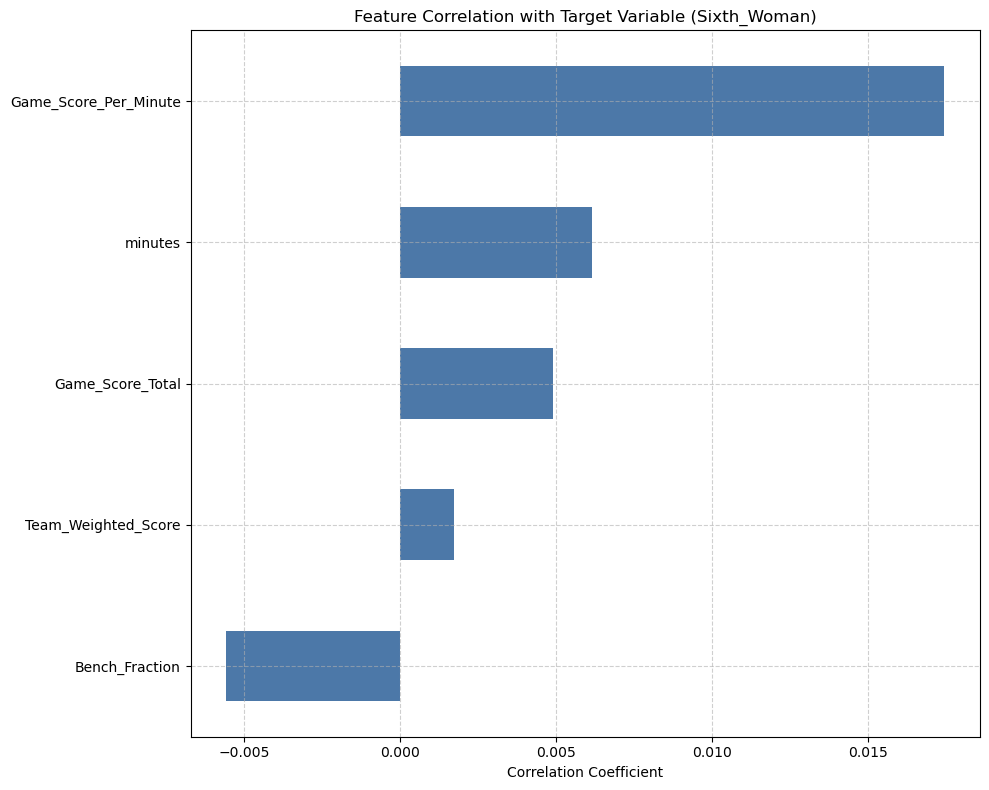

Top Positive Correlations:
Target                   1.000000
Game_Score_Per_Minute    0.017439
minutes                  0.006141
Game_Score_Total         0.004893
Team_Weighted_Score      0.001737
Bench_Fraction          -0.005554
Name: Target, dtype: float64

Top Negative Correlations:
Game_Score_Per_Minute    0.017439
minutes                  0.006141
Game_Score_Total         0.004893
Team_Weighted_Score      0.001737
Bench_Fraction          -0.005554
Name: Target, dtype: float64


In [19]:


# ===============================================
# FEATURE CORRELATION ANALYSIS (features vs Sixth_Woman target)
# ===============================================
import matplotlib.pyplot as plt

# Ensure historical dataset is available
try:
    _ = dataset_6th.shape
except NameError:
    dataset_6th = build_sixth_woman_dataset(players_teams, teams, awards, start_year=8, end_year=10)

# Engineered features and target
feature_columns = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                   "Team_Weighted_Score", "Bench_Fraction"]

# Filter to available columns
feature_columns = [c for c in feature_columns if c in dataset_6th.columns]

# Rename target to 'Target' for clarity
candidates = dataset_6th[feature_columns + ["Sixth_Woman"]].copy().fillna(0)
candidates = candidates.rename(columns={"Sixth_Woman": "Target"})

# Compute correlation of features with Target
correlation = candidates[feature_columns + ["Target"]].corr()["Target"].sort_values(ascending=False)

# Plot correlation (horizontal bar), invert y for descending order
plt.figure(figsize=(10, 8))
correlation.drop("Target").plot(kind="barh", color="#4C78A8")
plt.title("Feature Correlation with Target Variable (Sixth_Woman)")
plt.xlabel("Correlation Coefficient")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

print("Top Positive Correlations:")
print(correlation.head(6))
print("\nTop Negative Correlations:")
print(correlation.tail(5))


In [20]:
def evaluate_top_candidates_impact(model, players_teams, teams, feature_cols, years=[8, 9, 10], top_n=10,
                                   bench_threshold=0.5, gs_per_min_threshold=0.2):
    """
    Evaluate top N Sixth Woman candidates per year to see if they were high-impact bench players.

    Parameters:
        model: Trained RandomForestClassifier for Sixth Woman
        players_teams (pd.DataFrame): Player stats per team per year
        teams (pd.DataFrame): Team-level info
        feature_cols (list): Columns used in the model
        years (list): Years to evaluate
        top_n (int): Number of top candidates to check
        bench_threshold (float): Minimum fraction of minutes off the bench to count as bench player
        gs_per_min_threshold (float): Minimum Game_Score_Per_Minute to count as high-impact

    Returns:
        results_df (pd.DataFrame): Contains top candidates and whether they were high-impact bench players
    """
    results = []

    def is_high_impact_bench(player_id, year):
        """Helper to check if a player was high-impact off the bench.
        Computes Game_Score_Per_Minute from raw stats if the column is not present.
        """
        df = players_teams[(players_teams["playerID"] == player_id) & (players_teams["year"] == year)]
        if df.empty:
            return False

        # Aggregate player's stints if there are multiple rows
        needed_cols = [
            "points", "fgMade", "fgAttempted", "ftAttempted", "ftMade",
            "oRebounds", "dRebounds", "steals", "assists", "blocks",
            "PF", "turnovers", "minutes"
        ]
        agg = {c: (df[c].sum() if c in df.columns else 0) for c in needed_cols}
        agg["playerID"] = player_id
        agg["year"] = year
        # pick a representative tmID (first stint)
        agg["tmID"] = df["tmID"].iloc[0]

        player_df = pd.DataFrame([agg])
        # calculate Game_Score_Per_Minute using helper (handles division-by-zero)
        player_df = calculate_player_score(player_df)
        if "Game_Score_Per_Minute" in player_df.columns:
            gs_per_min = player_df["Game_Score_Per_Minute"].iloc[0]
        else:
            gs_per_min = 0

        # Bench fraction: 1 - player's minutes / total team minutes for that year
        team_minutes = players_teams[(players_teams["year"] == year) & (players_teams["tmID"] == agg["tmID"])]["minutes"].sum()
        player_minutes = player_df["minutes"].iloc[0] if "minutes" in player_df.columns else 0
        bench_frac = 1 - (player_minutes / team_minutes) if team_minutes > 0 else 0

        return (bench_frac >= bench_threshold) and (gs_per_min >= gs_per_min_threshold)

    for year in years:
        # Get top N candidates
        df_pred = preseason_sixth_woman_prediction(model, players_teams, teams, year, feature_cols, top_n=50)
        df_pred = rank_players_by_probability(df_pred)
        top_candidates = df_pred.head(top_n)

        # Check each candidate
        for i, row in top_candidates.iterrows():
            results.append({
                "year": year,
                "playerID": row["playerID"],
                "tmID": row["tmID"],
                "Predicted_Prob": row["Sixth_Woman_Probability"],
                "Predicted_Rank": row["Predicted_Rank"],
                "High_Impact_Bench": is_high_impact_bench(row["playerID"], year)
            })

    results_df = pd.DataFrame(results)
    
    # Optional: summary stats
    summary = results_df.groupby("year")["High_Impact_Bench"].mean().reset_index()
    summary.rename(columns={"High_Impact_Bench": f"Fraction_Top{top_n}_HighImpact"}, inplace=True)
    print(summary)

    return results_df


top_candidates_eval = evaluate_top_candidates_impact(
    model_6th, 
    players_teams, 
    teams, 
    feature_cols_6th, 
    years=[8, 9, 10], 
    top_n=10,
    bench_threshold=0.5,
    gs_per_min_threshold=0.2
)

print(top_candidates_eval)

   year  Fraction_Top10_HighImpact
0     8                        0.7
1     9                        0.7
2    10                        0.9
    year    playerID tmID  Predicted_Prob  Predicted_Rank  High_Impact_Bench
0      8  pierspl01w  DET           0.652               1               True
1      8  williad01w  MIN           0.034               2               True
2      8  turneba01w  SEA           0.012               3               True
3      8  lovelst01w  CHI           0.004               4              False
4      8  johnsvi01w  SAS           0.002               5               True
5      8  mabikmw01w  LAS           0.002               6              False
6      8  taylope01w  PHO           0.002               7               True
7      8  abrossv01w  MIN           0.000               8               True
8      8  beardal01w  WAS           0.000               9               True
9      8  anderam01w  CON           0.000              10              False
10     9  spe

## PREDICTION

In [21]:
# ===============================================
# PRESEASON PREDICTION FOR SEASON 11 (using test_data)
# Trains on seasons 8..10 (initial_data), predicts on year 11 rosters
# ===============================================
import pandas as pd
import numpy as np

# Define feature columns consistent with training
feature_cols_6th = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes", "Team_Weighted_Score", "Bench_Fraction"]

# 1) Train model on historical seasons (8..10) using initial_data
try:
    _ = dataset_6th.shape
except NameError:
    dataset_6th = build_sixth_woman_dataset(players_teams, teams, awards, start_year=8, end_year=10)
model_6th = train_sixth_woman_model(dataset_6th, feature_cols_6th)

# 2) Load test_data rosters for season 11 and build features from prior season (year 10 initial_data)
players_teams_initial = players_teams  # historic stats (year 10)
teams_year11_test = pd.read_csv("../../data/test_data/teams.csv")
players_teams_year11_test = pd.read_csv("../../data/test_data/players_teams.csv")

# Build player features from previous season stats (year 10 -> call with year=11)
player_features_11 = build_player_features(players_teams_initial, 11)

# Strict mapping: assign each player to their season 11 team from test_data
year11_map = players_teams_year11_test[players_teams_year11_test["year"] == 11][["playerID", "tmID"]].drop_duplicates()
player_features_11 = player_features_11.merge(year11_map, on="playerID", how="left")
valid_tmids = set(teams_year11_test[teams_year11_test["year"] == 11]["tmID"].unique())
player_features_11 = player_features_11[player_features_11["tmID_y"].isin(valid_tmids)]
player_features_11["tmID"] = player_features_11["tmID_y"]
player_features_11 = player_features_11.drop(columns=[col for col in ["tmID_y"] if col in player_features_11.columns])

# Build team features using year 11 test teams (for proper tmID coverage)
team_features_11 = build_team_features(players_teams_initial, teams_year11_test, 11)

# Merge player and team features
season11_df = merge_player_team_features_sixth(player_features_11, team_features_11)

# Bench fraction approximation for preseason (based on prior minutes share)
season11_df["Bench_Fraction"] = 1 - (season11_df["minutes"] / season11_df.groupby("tmID")["minutes"].transform("sum"))

# Predict probabilities
X_11 = season11_df[feature_cols_6th].fillna(0)
season11_df["Sixth_Woman_Probability"] = model_6th.predict_proba(X_11)[:, 1]

season11_pred = season11_df.sort_values("Sixth_Woman_Probability", ascending=False)[[
    "playerID", "tmID", "Sixth_Woman_Probability"
]].reset_index(drop=True)

print("=== Preseason Sixth Woman prediction for Season 11 ===")
print(season11_pred.head(15))

# Save to CSV
season11_pred.to_csv("sixth_woman_preseason_predictions_year11.csv", index=False)


=== Preseason Sixth Woman prediction for Season 11 ===
      playerID tmID  Sixth_Woman_Probability
0   parisco01w  ATL                    0.078
1   thorner01w  CHI                    0.064
2   hodgero01w  SAS                    0.044
3    snowmi01w  CHI                    0.022
4    holtam01w  TUL                    0.020
5   braxtka01w  NYL                    0.016
6   lawsoka01w  CON                    0.012
7     elysh01w  IND                    0.006
8   ferdima01w  PHO                    0.004
9   gardike01w  WAS                    0.004
10  holliqu01w  NYL                    0.004
11  jacksti02w  TUL                    0.004
12  januabr01w  IND                    0.002
13  mitchle01w  NYL                    0.002
14  lattaiv01w  TUL                    0.002
